In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import transformers
import wandb
import generate_plots

from dataloader import DataLoader
from evaluate import load
from trainer import CustomTrainer
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import load_dataset

# os.environ["CUDA_VISIBLE_DEVICES"]="0"

/vol/bitbucket/hrm20/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/vol/bitbucket/hrm20/env/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-02-26 20:39:42.733694: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-26 20:39:42.752578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1

In [2]:
torch.cuda.empty_cache()

# Load Dataset

In [3]:
os.environ["WANDB_MODE"] = "disabled"  # Disable wandb logging
os.environ["WANDB_DISABLED"] = "true"  # Fully disable wandb

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name = "google-bert/bert-base-uncased"
dataset_name = "multi_nli"

data_loader = DataLoader(dataset_name, model_name)
train_dataset, eval_dataset, tokenizer, num_labels = data_loader.prepare_datasets()

Using device: cuda


Map: 100%|██████████| 9832/9832 [00:02<00:00, 3436.15 examples/s]


# Train

In [4]:
import torch.nn as nn
import torch.optim as optim

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels  # MNLI has 3 classes: entailment, contradiction, neutral
)
model.to(device)

# Load accuracy metric
metric = load("accuracy")

num_epochs=2

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

wandb.init(
    project="bert_tiny_mnli",
    name=f"{num_epochs}_epochs_{dataset_name}_bert_tiny",
    # config=training_args.to_dict(),
)

trainer = CustomTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    optimizer = optim.Adam(model.parameters(), lr=2e-5, weight_decay=0.01),
    loss_fn=nn.CrossEntropyLoss(),
    methods=["loss", "forgetting"],  # Tracking loss and forgetting
    batch_size=96,
    shuffle=True,
    device=device,
)

trainer.train(epochs=num_epochs)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2


Training:   0%|▏                                                | 13/4091 [00:23<2:01:03,  1.78s/it]


KeyboardInterrupt: 

# Analysis

In [5]:
forgetting_results = trainer.get_unified_stats()['forgetting_stats']['forgetting_events']
epoch_losses = trainer.get_unified_stats()['loss_stats']['epoch_losses']
per_sample_losses = trainer.get_unified_stats()['loss_stats']['per_sample_losses']
all_losses = trainer.get_unified_stats()['loss_stats']['all_losses']
data_map_stats = trainer.get_unified_stats()["data_map_stats"]
aum_scores = trainer.get_unified_stats()["aum_stats"]['aum_scores']
sample_margins = trainer.get_unified_stats()["aum_stats"]['sample_margins']


predictions = trainer.get_unified_stats()['predictions']
true_labels = trainer.get_unified_stats()['true_labels']

total_samples = len(train_dataset)

## Forgetting

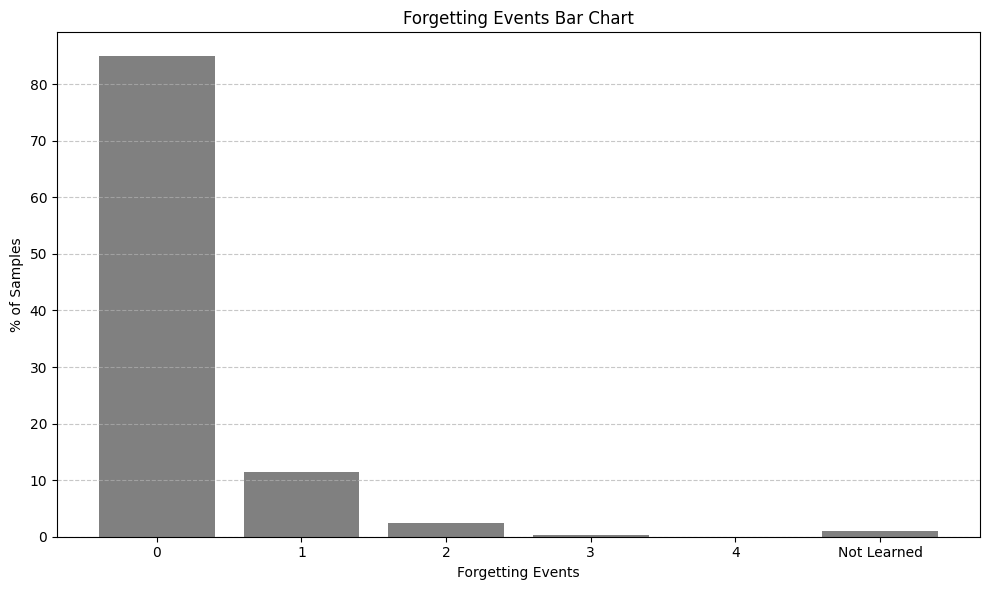

In [6]:
plt = generate_plots.plot_forgetting_events(forgetting_results=forgetting_results, total_samples=total_samples)
plt.savefig("forgetting_events.png")
wandb.log({"Forgetting Events Chart": wandb.Image("forgetting_events.png")})

plt.tight_layout()
plt.show()

## Losses

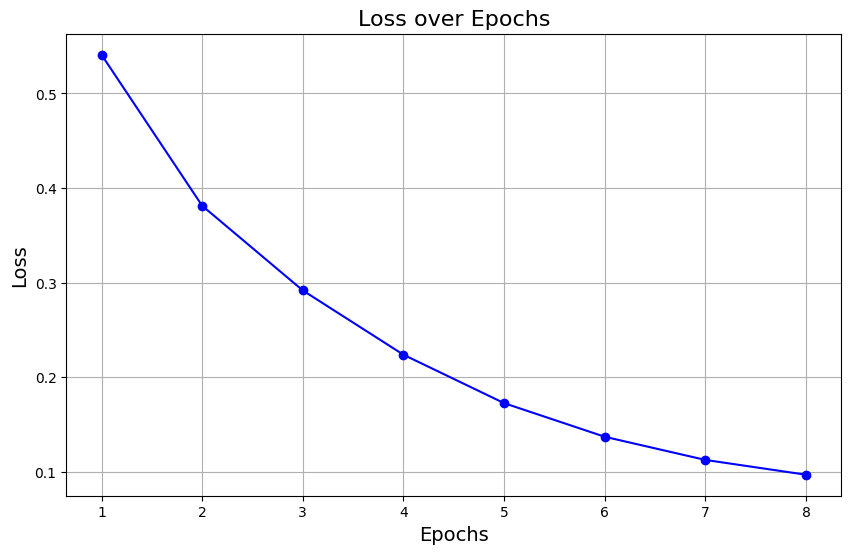

In [7]:
plt = generate_plots.plot_average_loss_over_epochs(epoch_losses)
plt.savefig("loss_over_epochs.png")
wandb.log({"Loss over Epochs": wandb.Image("loss_over_epochs.png")})
plt.show()

## Example Groups

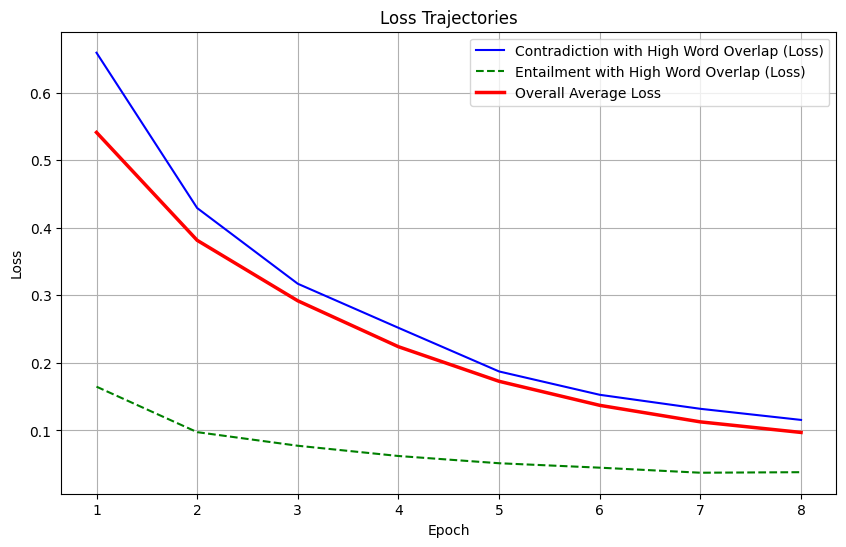

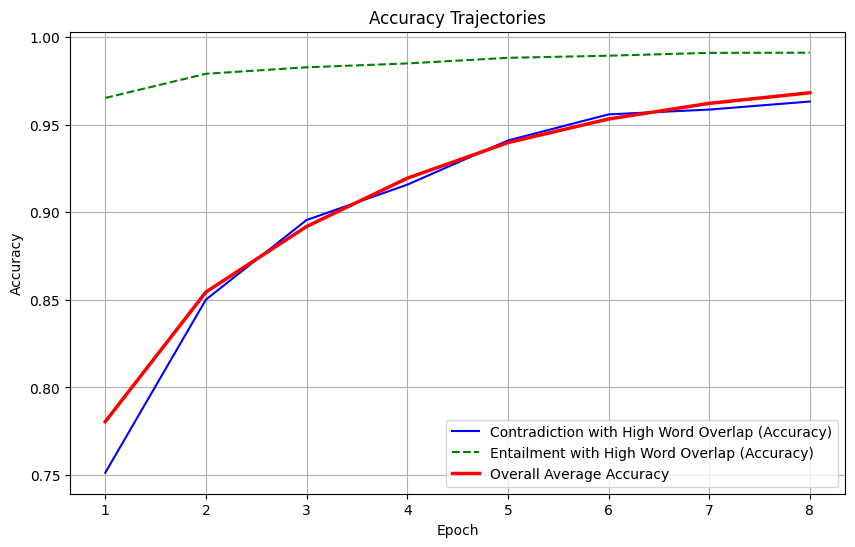

In [8]:
mnli = load_dataset('multi_nli')
fig1, fig2 = generate_plots.plot_losses_and_accuracies(mnli, all_losses, true_labels, predictions)
fig1.show()
fig2.show()

In [9]:
fig1.savefig("group_loss_trajectories.png")
fig2.savefig("group_accuracy_trajectories.png")
wandb.log({"Loss Trajectories for High Word Overlap Groups": wandb.Image("group_loss_trajectories.png")})
wandb.log({"Accuracy Trajectories for High Word Overlap Groups": wandb.Image("group_accuracy_trajectories.png")})

## Data Maps

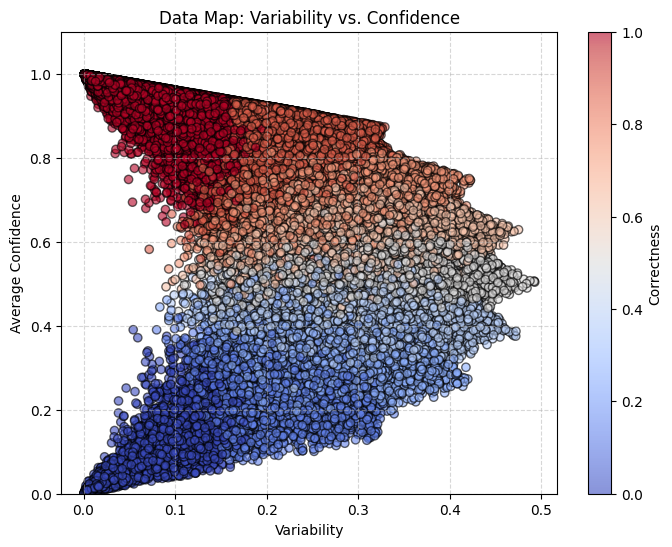

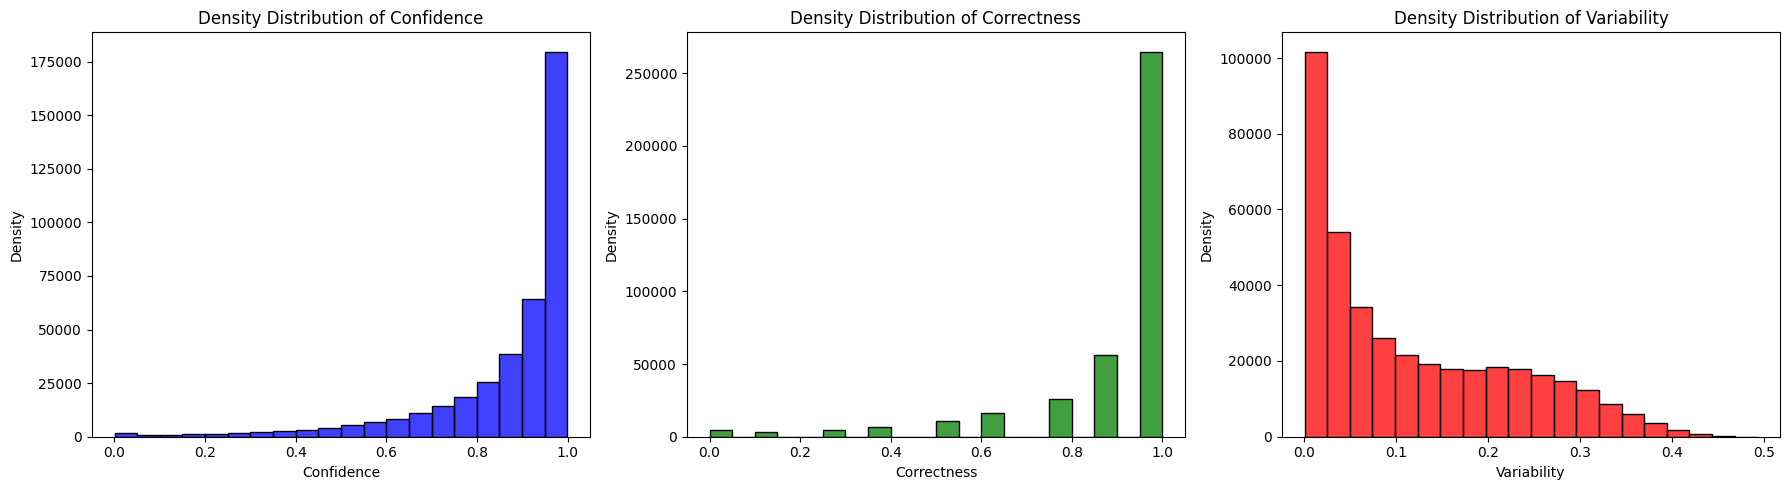

In [10]:
fig1, fig2 = generate_plots.plot_data_map(data_map_stats)
fig1.show()
fig2.show()
fig1.savefig("data_map.png")
fig2.savefig("data_map_variables.png")
wandb.log({"Data Map: Variability vs Confidence": wandb.Image("data_map.png")})
wandb.log({"Confidence, Correctness and Variability": wandb.Image("data_map_variables.png")})

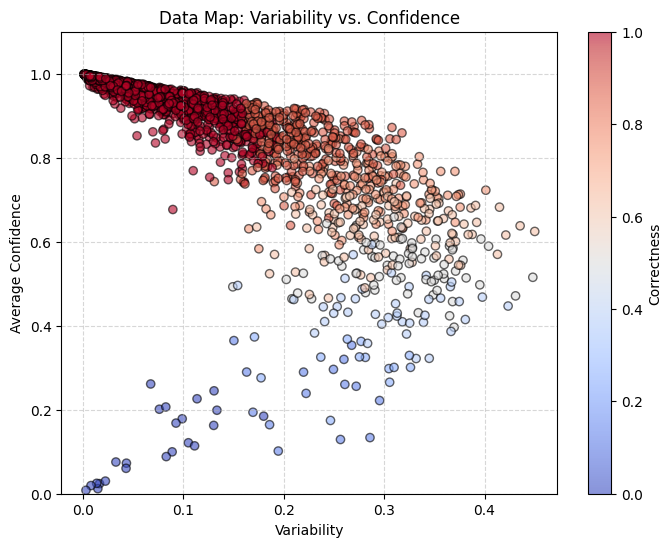

In [11]:
def plot_data_map(data_map_stats):
    confidence = np.array(data_map_stats["confidence"][:2500])
    variability = np.array(data_map_stats["variability"][:2500])
    correctness = np.array(data_map_stats["correctness"][:2500])

    # --- First Figure: Scatter Plot ---
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    scatter = ax1.scatter(variability, confidence, c=correctness, cmap="coolwarm", alpha=0.6, edgecolors="k")
    ax1.set_xlabel("Variability")
    ax1.set_ylabel("Average Confidence")
    ax1.set_ylim(0, 1.1)
    ax1.set_title("Data Map: Variability vs. Confidence")
    fig1.colorbar(scatter, ax=ax1, label="Correctness")
    ax1.grid(True, linestyle="--", alpha=0.5)
    return fig1
fig = plot_data_map(data_map_stats)
fig.show()
fig.savefig("data_map_2k_examples.png")
wandb.log({"Smaller Data Map: Variability vs Confidence": wandb.Image("data_map_2k_examples.png")})

## AUM

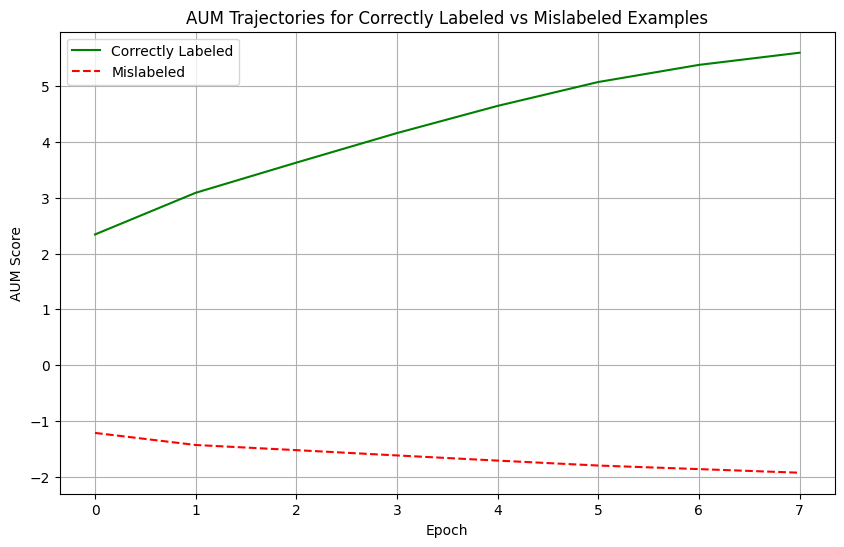

<Figure size 640x480 with 0 Axes>

In [12]:
plt = generate_plots.plot_aum(sample_margins, true_labels, predictions)
plt.show()
plt.savefig("aum_labeled_vs_mislabeled.png")
wandb.log({"AUM Trajectories for Labeled and Mislabeled Examples": wandb.Image("aum_labeled_vs_mislabeled.png")})

In [13]:
wandb.log({
    "epoch_losses": epoch_losses,
    "per_sample_losses": per_sample_losses,
    "final_forgetting_stats": forgetting_results,
    "all_losses": all_losses,
    "data_map_stats": data_map_stats,
    "sample_margins": sample_margins,
    "predictions": predictions
})

wandb: WARNING Serializing object of type ndarray that is 3141728 bytes
wandb: WARNING Serializing object of type ndarray that is 3141728 bytes
wandb: WARNING Serializing object of type ndarray that is 3141728 bytes


In [14]:
wandb.finish()

eval/accuracy,▁▆█▇▆▆▆▆
eval/loss,▁▁▁▃▄▆▇█
eval/runtime,▄▁▁█▂▂▂▂
eval/samples_per_second,▅██▁▇▇▇▇
eval/steps_per_second,▅██▁▇▇▇▇
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇███████
train/grad_norm,▂▂▂▂▁▁▂▂▂▂▁▂▂▂▂▂▃▃▂▂▂▂▂▂▂▂▂█▃▃▃▂▁▄▃▃▂▄▃▂
train/learning_rate,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁
train/loss,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/accuracy,0.83974
